# Experiment on imputation methods

**How to deal with null/emtpy values**

## Table of contents

[0. Introduction](#bullet-0)
* [0.a) Data creation](#bullet-0a)
* [0.b) Set the environment and load the data](#bullet-0b)

[1. Imputation of x features](#bullet-1)
* [1.a) Mean imputation](#bullet-1a)
* [1.b) MICE](#bullet-1b)
* [1.c) KNN Imputer](#bullet-1c)

[2. Imputation results](#bullet-2)
* [2.a) 20% null values](#bullet-2a)
* [2.b) 80% null values](#bullet-2b)

[3. Model predictions results](#bullet-3)

[4. Conclusions](#bullet-4)


## 0. Introduction <a class="anchor" id="bullet-0"></a>

As we learn how to make our Data Science projects as scientific and accurate as possible, different methods and procedures are to be learnt. Quite often, several methods exist to solve the same issue. One of these situations is dealing with null/empty values.

An interesting article on different ways of dealing with null values can be found [here](https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87). However, the article demonstrates how to apply the different methods, but doesn't compare their effectiveness. This leads us to the goal of this project.

#### Project goal

<ins>The goal of this experiment is to compare the accurateness of different imputation methods</ins>. We'll do so by using a dataset created using [Google Sheets](https://docs.google.com/spreadsheets/) where we have related x features and a target variable y. Besides that original dataset, we'll use two additional datasets that resemble the original dataset, but with 20% or 80% empty values. Let's check how the data was created with more detail:

### 0.a) Data creation <a class="anchor" id="bullet-0a"></a>

#### Original dataset

The dataset "Imputations_experiment - Complete" contains 1000 rows with 0 null/empty values. We'll use row number 2 (row number 1 contains headers) to illustrate the formulas here:

- column A: **x1_rand_0_1000** = RANDBETWEEN(0;1000)

- column B: **cat_x1_250** = IF(A2<250;1;0)

- column C: **x2_3x1_20perc** = 3*A2+RANDBETWEEN(-0,2*A2;0,2*A2)

- column D: **cat_x2_700** = IF(C2<700;1;0)

- column E: **x3_4xsquared_50perc** = 4*A2^2+RANDBETWEEN(-0,5*A2;0,5*A2)

- column F: **cat_x3_500000** = IF(E2<500000;1;0)

- column G: **y** = 0,3*A2^3-0,2*C2^2+0,1*E2

#### Modified datasets with missing values

The datasets "Imputations_experiment - Null_20perc" and "Imputations_experiment - Null_80perc" basically refer to
"Imputations_experiment - Complete" except for some rows that will have empty values. Let us examine the row number 2
from "Imputations_experiment - Null_20perc" as an example:

column A: **x1_rand_0_1000** = Complete!A2

column B: **cat_x1_250** = IF($H2=0;Complete!B2;"")

column C: **x2_3x1_20perc** = IF($H2=0;Complete!C2;"")

column D: **cat_x2_700** = IF($H2=0;Complete!D2;"")

column E: **x3_4xsquared_50perc** = IF($H2=0;Complete!E2;"")

column F: **cat_x3_500000** = IF($H2=0;Complete!F2;"")

column G: **y** = IF($H2=0;Complete!G2;"")

column H: **null_20perc** = =IF(RAND()<0,2;1;0)


The dataset "Imputations_experiment - Null_80perc" is exactly the same, but the column H changes to:

column H: **null_20perc** = =IF(RAND()<0,8;1;0)


### 0.b) Set the environment and load the data <a class="anchor" id="bullet-0b"></a>

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from impyute.imputation.cs import mice
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Remove scientific notation by setting floats to 1 decimal point
pd.options.display.float_format = '{:.1f}'.format

# Load the dataframes
all_x_y_com = pd.read_csv("Imputations_experiment - Complete.csv", decimal=",")
all_x_y_del20 = pd.read_csv("Imputations_experiment - Null_20perc.csv", decimal=",")
all_x_y_del80 = pd.read_csv("Imputations_experiment - Null_80perc.csv", decimal=",")

# Separate into x features to test imputation and y features to test model predictions
df_com = all_x_y_com.iloc[:, :-1]
df_del20 = all_x_y_del20.iloc[:, :-2]
df_del80 = all_x_y_del80.iloc[:, :-2]

y_com = all_x_y_com["y"]
y_del20 = all_x_y_del20["y"]
y_del80 = all_x_y_del80["y"]

# Create a mask with the null values index
null_mask20 = df_del20.isna().any(axis=1)
null_mask80 = df_del80.isna().any(axis=1)

# # Create a mask for the related columns (two parts)
# rel_cols12 = ["Cat_var_num1", "Cat_var_num2", "Num_var1", "Num_var2", "Sum_num12"]
# rel_cols34 = ["Cat_var_num3", "Cat_var_num4", "Num_var3", "Num_var4", "Sum_num34"]

# Initiate two dictionaries to store values:
results20 = {}
results80 = {}

# Display info about dataframes
print("\nDataframe with complete data head and sum of nulls:")
display(df_com.head(), df_com.isna().sum())

print("\nDataframe with missing data (20% nulls) head and sum of nulls:")
display(df_del20.head(), df_del20.isna().sum())

print("\nRows with missing data (20% nulls):")
display(df_del20[null_mask20].head())

print("\nDataframe with missing data (80% nulls) head and sum of nulls:")
display(df_del80.head(), df_del80.isna().sum())

print("\nRows with missing data (20% nulls):")
display(df_del80[null_mask20].head())


Dataframe with complete data head and sum of nulls:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,0,1786,0,1617977,0
1,514,0,1449,0,1056853,0
2,809,0,2271,0,2617790,0
3,128,1,360,1,65554,1
4,583,0,1800,0,1359720,0


x1_rand_0_1000         0
cat_x1_250             0
x2_3x1_20perc          0
cat_x2_700             0
x3_4xsquared_50perc    0
cat_x3_500000          0
dtype: int64


Dataframe with missing data (20% nulls) head and sum of nulls:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,0.0,1786.0,0.0,1617977.0,0.0
1,514,0.0,1449.0,0.0,1056853.0,0.0
2,809,0.0,2271.0,0.0,2617790.0,0.0
3,128,1.0,360.0,1.0,65554.0,1.0
4,583,0.0,1800.0,0.0,1359720.0,0.0


x1_rand_0_1000           0
cat_x1_250             205
x2_3x1_20perc          205
cat_x2_700             205
x3_4xsquared_50perc    205
cat_x3_500000          205
dtype: int64


Rows with missing data (20% nulls):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,NaN,NaN,NaN,NaN,NaN
16,346,NaN,NaN,NaN,NaN,NaN
22,1000,NaN,NaN,NaN,NaN,NaN
31,914,NaN,NaN,NaN,NaN,NaN
33,856,NaN,NaN,NaN,NaN,NaN



Dataframe with missing data (80% nulls) head and sum of nulls:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,NaN,NaN,NaN,NaN,NaN
1,514,NaN,NaN,NaN,NaN,NaN
2,809,NaN,NaN,NaN,NaN,NaN
3,128,NaN,NaN,NaN,NaN,NaN
4,583,NaN,NaN,NaN,NaN,NaN


x1_rand_0_1000           0
cat_x1_250             797
x2_3x1_20perc          797
cat_x2_700             797
x3_4xsquared_50perc    797
cat_x3_500000          797
dtype: int64


Rows with missing data (20% nulls):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,NaN,NaN,NaN,NaN,NaN
16,346,0.0,1054.0,0.0,478941.0,1.0
22,1000,NaN,NaN,NaN,NaN,NaN
31,914,NaN,NaN,NaN,NaN,NaN
33,856,0.0,2684.0,0.0,2931217.0,0.0


## 1. Imputation of x features <a class="anchor" id="bullet-1"></a>

### 1.a) Mean imputation <a class="anchor" id="bullet-1a"></a>

#### Test with 20% missing data

In [2]:
# Impute values with mean
mean_df20 = df_del20.copy()
for column in mean_df20.columns:
    mean_df20[column].fillna(mean_df20[column].mean(), inplace=True)

print("\nNull rows from dataframe with raw imputed values:")
display(mean_df20[null_mask20].head())

# Round imputed values to 0 or 1
rounded_data20 = np.where((mean_df20 > .5) & (mean_df20 < 1), 1,
                          np.where((mean_df20 > .0) & (mean_df20 < .5), 0, mean_df20))
rounded_df20 = pd.DataFrame(rounded_data20, columns = mean_df20.columns)

print("\nNull rows from dataframe with rounded imputed values:")
display(rounded_df20[null_mask20].head())

# Display actual values from complete dataframes
print("\nNull rows from dataframe with original values:")
display(df_com[null_mask20].head())

# Calculate results of accurateness
acc_cat_x1_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x1_250"] - mean_df20.loc[null_mask20, "cat_x1_250"]))
acc_cat_x1_round = np.mean(df_com.loc[null_mask20, "cat_x1_250"] == rounded_df20.loc[null_mask20, "cat_x1_250"])
acc_x2 = np.mean(abs(df_com.loc[null_mask20, "x2_3x1_20perc"] - rounded_df20.loc[null_mask20, "x2_3x1_20perc"]))
acc_cat_x2_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x2_700"] - mean_df20.loc[null_mask20, "cat_x2_700"]))
acc_cat_x2_round = np.mean(df_com.loc[null_mask20, "cat_x2_700"] == rounded_df20.loc[null_mask20, "cat_x2_700"])
acc_x3 = np.mean(abs(df_com.loc[null_mask20, "x3_4xsquared_50perc"] - rounded_df20.loc[null_mask20, "x3_4xsquared_50perc"]))
acc_cat_x3_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x3_500000"] - mean_df20.loc[null_mask20, "cat_x3_500000"]))
acc_cat_x3_round = np.mean(df_com.loc[null_mask20, "cat_x3_500000"] == rounded_df20.loc[null_mask20, "cat_x3_500000"])

# Append results to dictionary
results20["Mean_20nulls_Cat_x1_raw"] = acc_cat_x1_raw
results20["Mean_20nulls_Cat_x1_round"] = acc_cat_x1_round
results20["Mean_20nulls_x2"] = acc_x2
results20["Mean_20nulls_Cat_x2_raw"] = acc_cat_x2_raw
results20["Mean_20nulls_Cat_x2_round"] = acc_cat_x2_round
results20["Mean_20nulls_x3"] = acc_x3
results20["Mean_20nulls_Cat_x3_raw"] = acc_cat_x3_raw
results20["Mean_20nulls_Cat_x3_round"] = acc_cat_x3_round

# Display results from the analysis
print("\nMean deviation for categorical feature x1 missing 20%:", round(acc_cat_x1_raw, 4))
print("\n% of correct predictions for rounded categorical feature x1 missing 20%:", round(acc_cat_x1_round, 4))
print("\nMean deviation for numerical feature x2 missing 20%:", round(acc_x2, 4))
print("\nMean deviation for categorical feature x2 missing 20%:", round(acc_cat_x2_raw, 4))
print("\n% of correct predictions for rounded categorical feature x2 missing 20%:", round(acc_cat_x2_round, 4))
print("\nMean deviation for numerical feature x3 missing 20%:", round(acc_x3, 4))
print("\nMean deviation for categorical feature x3 missing 20%:", round(acc_cat_x3_raw, 4))
print("\n% of correct predictions for rounded categorical feature x3 missing 20%:", round(acc_cat_x3_round, 4))


Null rows from dataframe with raw imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0.3,1461.8,0.3,1281030.9,0.4
16,346,0.3,1461.8,0.3,1281030.9,0.4
22,1000,0.3,1461.8,0.3,1281030.9,0.4
31,914,0.3,1461.8,0.3,1281030.9,0.4
33,856,0.3,1461.8,0.3,1281030.9,0.4



Null rows from dataframe with rounded imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,1461.8,0.0,1281030.9,0.0
16,346.0,0.0,1461.8,0.0,1281030.9,0.0
22,1000.0,0.0,1461.8,0.0,1281030.9,0.0
31,914.0,0.0,1461.8,0.0,1281030.9,0.0
33,856.0,0.0,1461.8,0.0,1281030.9,0.0



Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Mean deviation for categorical feature x1 missing 20%: 0.3721

% of correct predictions for rounded categorical feature x1 missing 20%: 0.7756

Mean deviation for numerical feature x2 missing 20%: 745.0062

Mean deviation for categorical feature x2 missing 20%: 0.3606

% of correct predictions for rounded categorical feature x2 missing 20%: 0.7805

Mean deviation for numerical feature x3 missing 20%: 1011768.3365

Mean deviation for categorical feature x3 missing 20%: 0.4532

% of correct predictions for rounded categorical feature x3 missing 20%: 0.678


#### Test with 80% missing data

In [3]:
# Impute values with mean
mean_df80 = df_del80.copy()
for column in mean_df80.columns:
    mean_df80[column].fillna(mean_df80[column].mean(), inplace=True)

print("\nNull rows from dataframe with raw imputed values:")
display(mean_df80[null_mask80].head())

# Round imputed values to 0 or 1
rounded_data80 = np.where((mean_df80 > .5) & (mean_df80 < 1), 1,
                          np.where((mean_df80 > .0) & (mean_df80 < .5), 0, mean_df80))
rounded_df80 = pd.DataFrame(rounded_data80, columns = mean_df80.columns)

print("\nNull rows from dataframe with rounded imputed values:")
display(rounded_df80[null_mask80].head())

# Display actual values from complete dataframes
print("\nNull rows from dataframe with original values:")
display(df_com[null_mask80].head())

# Calculate results of accurateness
acc_cat_x1_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x1_250"] - mean_df80.loc[null_mask80, "cat_x1_250"]))
acc_cat_x1_round = np.mean(df_com.loc[null_mask80, "cat_x1_250"] == rounded_df80.loc[null_mask80, "cat_x1_250"])
acc_x2 = np.mean(abs(df_com.loc[null_mask80, "x2_3x1_20perc"] - rounded_df80.loc[null_mask80, "x2_3x1_20perc"]))
acc_cat_x2_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x2_700"] - mean_df80.loc[null_mask80, "cat_x2_700"]))
acc_cat_x2_round = np.mean(df_com.loc[null_mask80, "cat_x2_700"] == rounded_df80.loc[null_mask80, "cat_x2_700"])
acc_x3 = np.mean(abs(df_com.loc[null_mask80, "x3_4xsquared_50perc"] - rounded_df80.loc[null_mask80, "x3_4xsquared_50perc"]))
acc_cat_x3_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x3_500000"] - mean_df80.loc[null_mask80, "cat_x3_500000"]))
acc_cat_x3_round = np.mean(df_com.loc[null_mask80, "cat_x3_500000"] == rounded_df80.loc[null_mask80, "cat_x3_500000"])

# Append results to dictionary
results80["Mean_80nulls_Cat_x1_raw"] = acc_cat_x1_raw
results80["Mean_80nulls_Cat_x1_round"] = acc_cat_x1_round
results80["Mean_80nulls_x2"] = acc_x2
results80["Mean_80nulls_Cat_x2_raw"] = acc_cat_x2_raw
results80["Mean_80nulls_Cat_x2_round"] = acc_cat_x2_round
results80["Mean_80nulls_x3"] = acc_x3
results80["Mean_80nulls_Cat_x3_raw"] = acc_cat_x3_raw
results80["Mean_80nulls_Cat_x3_round"] = acc_cat_x3_round

# Display results from the analysis
print("\nMean deviation for categorical feature x1 missing 80%:", round(acc_cat_x1_raw, 4))
print("\n% of correct predictions for rounded categorical feature x1 missing 80%:", round(acc_cat_x1_round, 4))
print("\nMean deviation for numerical feature x2 missing 80%:", round(acc_x2, 4))
print("\nMean deviation for categorical feature x2 missing 80%:", round(acc_cat_x2_raw, 4))
print("\n% of correct predictions for rounded categorical feature x2 missing 80%:", round(acc_cat_x2_round, 4))
print("\nMean deviation for numerical feature x3 missing 80%:", round(acc_x3, 4))
print("\nMean deviation for categorical feature x3 missing 80%:", round(acc_cat_x3_raw, 4))
print("\n% of correct predictions for rounded categorical feature x3 missing 80%:", round(acc_cat_x3_round, 4))


Null rows from dataframe with raw imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,0.2,1586.6,0.2,1428576.6,0.3
1,514,0.2,1586.6,0.2,1428576.6,0.3
2,809,0.2,1586.6,0.2,1428576.6,0.3
3,128,0.2,1586.6,0.2,1428576.6,0.3
4,583,0.2,1586.6,0.2,1428576.6,0.3



Null rows from dataframe with rounded imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636.0,0.0,1586.6,0.0,1428576.6,0.0
1,514.0,0.0,1586.6,0.0,1428576.6,0.0
2,809.0,0.0,1586.6,0.0,1428576.6,0.0
3,128.0,0.0,1586.6,0.0,1428576.6,0.0
4,583.0,0.0,1586.6,0.0,1428576.6,0.0



Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,0,1786,0,1617977,0
1,514,0,1449,0,1056853,0
2,809,0,2271,0,2617790,0
3,128,1,360,1,65554,1
4,583,0,1800,0,1359720,0



Mean deviation for categorical feature x1 missing 80%: 0.3696

% of correct predictions for rounded categorical feature x1 missing 80%: 0.7302

Mean deviation for numerical feature x2 missing 80%: 757.5872

Mean deviation for categorical feature x2 missing 80%: 0.3579

% of correct predictions for rounded categorical feature x2 missing 80%: 0.7465

Mean deviation for numerical feature x3 missing 80%: 1046985.8892

Mean deviation for categorical feature x3 missing 80%: 0.4546

% of correct predictions for rounded categorical feature x3 missing 80%: 0.6336


### 1.b) [MICE](https://impyute.readthedocs.io/en/master/_modules/impyute/imputation/cs/mice.html) <a class="anchor" id="bullet-1b"></a>

#### Test with 20% missing data

In [4]:
# Impute values with MICE
imp_df20_mice = pd.DataFrame(mice(df_del20.values), columns=df_del20.columns)
print("\nNull rows from dataframe with raw imputed values:")
display(imp_df20_mice[null_mask20].head())

# Round imputed values to 0 or 1
rounded_data20 = np.where((imp_df20_mice > .5) & (imp_df20_mice < 1), 1, np.where((imp_df20_mice > .0) & (imp_df20_mice < .5), 0, imp_df20_mice))
rounded_df20 = pd.DataFrame(rounded_data20, columns = imp_df20_mice.columns)

print("\nNull rows from dataframe with rounded imputed values:")
display(rounded_df20[null_mask20].head())

# Display actual values from complete dataframes
print("\nNull rows from dataframe with original values:")
display(df_com[null_mask20].head())

# Calculate results of accurateness
acc_cat_x1_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x1_250"] - imp_df20_mice.loc[null_mask20, "cat_x1_250"]))
acc_cat_x1_round = np.mean(df_com.loc[null_mask20, "cat_x1_250"] == rounded_df20.loc[null_mask20, "cat_x1_250"])
acc_x2 = np.mean(abs(df_com.loc[null_mask20, "x2_3x1_20perc"] - rounded_df20.loc[null_mask20, "x2_3x1_20perc"]))
acc_cat_x2_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x2_700"] - imp_df20_mice.loc[null_mask20, "cat_x2_700"]))
acc_cat_x2_round = np.mean(df_com.loc[null_mask20, "cat_x2_700"] == rounded_df20.loc[null_mask20, "cat_x2_700"])
acc_x3 = np.mean(abs(df_com.loc[null_mask20, "x3_4xsquared_50perc"] - rounded_df20.loc[null_mask20, "x3_4xsquared_50perc"]))
acc_cat_x3_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x3_500000"] - imp_df20_mice.loc[null_mask20, "cat_x3_500000"]))
acc_cat_x3_round = np.mean(df_com.loc[null_mask20, "cat_x3_500000"] == rounded_df20.loc[null_mask20, "cat_x3_500000"])

# Append results to dictionary
results20["MICE_20nulls_Cat_x1_raw"] = acc_cat_x1_raw
results20["MICE_20nulls_Cat_x1_round"] = acc_cat_x1_round
results20["MICE_20nulls_x2"] = acc_x2
results20["MICE_20nulls_Cat_x2_raw"] = acc_cat_x2_raw
results20["MICE_20nulls_Cat_x2_round"] = acc_cat_x2_round
results20["MICE_20nulls_x3"] = acc_x3
results20["MICE_20nulls_Cat_x3_raw"] = acc_cat_x3_raw
results20["MICE_20nulls_Cat_x3_round"] = acc_cat_x3_round

# Display results from the analysis
print("\nMean deviation for categorical feature x1 missing 20%:", round(acc_cat_x1_raw, 4))
print("\n% of correct predictions for rounded categorical feature x1 missing 20%:", round(acc_cat_x1_round, 4))
print("\nMean deviation for numerical feature x2 missing 20%:", round(acc_x2, 4))
print("\nMean deviation for categorical feature x2 missing 20%:", round(acc_cat_x2_raw, 4))
print("\n% of correct predictions for rounded categorical feature x2 missing 20%:", round(acc_cat_x2_round, 4))
print("\nMean deviation for numerical feature x3 missing 20%:", round(acc_x3, 4))
print("\nMean deviation for categorical feature x3 missing 20%:", round(acc_cat_x3_raw, 4))
print("\n% of correct predictions for rounded categorical feature x3 missing 20%:", round(acc_cat_x3_round, 4))


Null rows from dataframe with raw imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.5,825.8,0.5,432362.8,0.7
16,346.0,0.4,1039.0,0.4,716826.2,0.6
22,1000.0,-0.3,3002.8,-0.3,3337095.0,-0.3
31,914.0,-0.2,2744.6,-0.2,2992533.7,-0.2
33,856.0,-0.2,2570.4,-0.2,2760155.1,-0.1



Null rows from dataframe with rounded imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,1.0,825.8,0.0,432362.8,1.0
16,346.0,0.0,1039.0,0.0,716826.2,1.0
22,1000.0,-0.3,3002.8,-0.3,3337095.0,-0.3
31,914.0,-0.2,2744.6,-0.2,2992533.7,-0.2
33,856.0,-0.2,2570.4,-0.2,2760155.1,-0.1



Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Mean deviation for categorical feature x1 missing 20%: 0.2448

% of correct predictions for rounded categorical feature x1 missing 20%: 0.6244

Mean deviation for numerical feature x2 missing 20%: 46.0752

Mean deviation for categorical feature x2 missing 20%: 0.2448

% of correct predictions for rounded categorical feature x2 missing 20%: 0.6537

Mean deviation for numerical feature x3 missing 20%: 240656.3662

Mean deviation for categorical feature x3 missing 20%: 0.2217

% of correct predictions for rounded categorical feature x3 missing 20%: 0.6683


#### Test with 80% missing data

In [5]:
# Impute values with MICE
imp_df80_mice = pd.DataFrame(mice(df_del80.values), columns=df_del80.columns)
print("\nNull rows from dataframe with raw imputed values:")
display(imp_df80_mice[null_mask80].head())

# Round imputed values to 0 or 1
rounded_data80 = np.where((imp_df80_mice > .5) & (imp_df80_mice < 1), 1, np.where((imp_df80_mice > .0) & (imp_df80_mice < .5), 0, imp_df80_mice))
rounded_df80 = pd.DataFrame(rounded_data80, columns = imp_df80_mice.columns)

print("\nNull rows from dataframe with rounded imputed values:")
display(rounded_df80[null_mask80].head())

# Display actual values from complete dataframes
print("\nNull rows from dataframe with original values:")
display(df_com[null_mask80].head())

# Calculate results of accurateness
acc_cat_x1_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x1_250"] - imp_df80_mice.loc[null_mask80, "cat_x1_250"]))
acc_cat_x1_round = np.mean(df_com.loc[null_mask80, "cat_x1_250"] == rounded_df80.loc[null_mask80, "cat_x1_250"])
acc_x2 = np.mean(abs(df_com.loc[null_mask80, "x2_3x1_20perc"] - rounded_df80.loc[null_mask80, "x2_3x1_20perc"]))
acc_cat_x2_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x2_700"] - imp_df80_mice.loc[null_mask80, "cat_x2_700"]))
acc_cat_x2_round = np.mean(df_com.loc[null_mask80, "cat_x2_700"] == rounded_df80.loc[null_mask80, "cat_x2_700"])
acc_x3 = np.mean(abs(df_com.loc[null_mask80, "x3_4xsquared_50perc"] - rounded_df80.loc[null_mask80, "x3_4xsquared_50perc"]))
acc_cat_x3_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x3_500000"] - imp_df80_mice.loc[null_mask80, "cat_x3_500000"]))
acc_cat_x3_round = np.mean(df_com.loc[null_mask80, "cat_x3_500000"] == rounded_df80.loc[null_mask80, "cat_x3_500000"])

# Append results to dictionary
results80["MICE_80nulls_Cat_x1_raw"] = acc_cat_x1_raw
results80["MICE_80nulls_Cat_x1_round"] = acc_cat_x1_round
results80["MICE_80nulls_x2"] = acc_x2
results80["MICE_80nulls_Cat_x2_raw"] = acc_cat_x2_raw
results80["MICE_80nulls_Cat_x2_round"] = acc_cat_x2_round
results80["MICE_80nulls_x3"] = acc_x3
results80["MICE_80nulls_Cat_x3_raw"] = acc_cat_x3_raw
results80["MICE_80nulls_Cat_x3_round"] = acc_cat_x3_round

# Display results from the analysis
print("\nMean deviation for categorical feature x1 missing 80%:", round(acc_cat_x1_raw, 4))
print("\n% of correct predictions for rounded categorical feature x1 missing 80%:", round(acc_cat_x1_round, 4))
print("\nMean deviation for numerical feature x2 missing 80%:", round(acc_x2, 4))
print("\nMean deviation for categorical feature x2 missing 80%:", round(acc_cat_x2_raw, 4))
print("\n% of correct predictions for rounded categorical feature x2 missing 80%:", round(acc_cat_x2_round, 4))
print("\nMean deviation for numerical feature x3 missing 80%:", round(acc_x3, 4))
print("\nMean deviation for categorical feature x3 missing 80%:", round(acc_cat_x3_raw, 4))
print("\n% of correct predictions for rounded categorical feature x3 missing 80%:", round(acc_cat_x3_round, 4))


Null rows from dataframe with raw imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636.0,0.1,1920.0,0.1,1909779.2,0.2
1,514.0,0.2,1551.2,0.2,1377511.9,0.3
2,809.0,0.0,2443.0,0.0,2664551.5,-0.0
3,128.0,0.5,384.2,0.5,-306546.6,0.8
4,583.0,0.2,1759.8,0.2,1678548.3,0.3



Null rows from dataframe with rounded imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636.0,0.0,1920.0,0.0,1909779.2,0.0
1,514.0,0.0,1551.2,0.0,1377511.9,0.0
2,809.0,0.0,2443.0,0.0,2664551.5,-0.0
3,128.0,1.0,384.2,0.0,-306546.6,1.0
4,583.0,0.0,1759.8,0.0,1678548.3,0.0



Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,0,1786,0,1617977,0
1,514,0,1449,0,1056853,0
2,809,0,2271,0,2617790,0
3,128,1,360,1,65554,1
4,583,0,1800,0,1359720,0



Mean deviation for categorical feature x1 missing 80%: 0.2644

% of correct predictions for rounded categorical feature x1 missing 80%: 0.7102

Mean deviation for numerical feature x2 missing 80%: 48.702

Mean deviation for categorical feature x2 missing 80%: 0.2623

% of correct predictions for rounded categorical feature x2 missing 80%: 0.7001

Mean deviation for numerical feature x3 missing 80%: 264088.3487

Mean deviation for categorical feature x3 missing 80%: 0.234

% of correct predictions for rounded categorical feature x3 missing 80%: 0.7629


### 1.c) [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) <a class="anchor" id="bullet-1c"></a>

#### Test with 20% missing data

In [6]:
# Impute values with KNNImputer
imputer = KNNImputer()
imp_df20_knn = pd.DataFrame(imputer.fit_transform(df_del20), columns=df_del20.columns)

print("\nNull rows from dataframe with raw imputed values:")
display(imp_df20_knn[null_mask20].head())

# Round imputed values to 0 or 1
rounded_data20 = np.where((imp_df20_knn > .5) & (imp_df20_knn < 1), 1,
                          np.where((imp_df20_knn > .0) & (imp_df20_knn < .5), 0, imp_df20_knn))
rounded_df20 = pd.DataFrame(rounded_data20, columns = imp_df20_knn.columns)

print("\nNull rows from dataframe with rounded imputed values:")
display(rounded_df20[null_mask20].head())

# Display actual values from complete dataframes
print("\nNull rows from dataframe with original values:")
display(df_com[null_mask20].head())

# Calculate results of accurateness
acc_cat_x1_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x1_250"] - imp_df20_knn.loc[null_mask20, "cat_x1_250"]))
acc_cat_x1_round = np.mean(df_com.loc[null_mask20, "cat_x1_250"] == rounded_df20.loc[null_mask20, "cat_x1_250"])
acc_x2 = np.mean(abs(df_com.loc[null_mask20, "x2_3x1_20perc"] - rounded_df20.loc[null_mask20, "x2_3x1_20perc"]))
acc_cat_x2_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x2_700"] - imp_df20_knn.loc[null_mask20, "cat_x2_700"]))
acc_cat_x2_round = np.mean(df_com.loc[null_mask20, "cat_x2_700"] == rounded_df20.loc[null_mask20, "cat_x2_700"])
acc_x3 = np.mean(abs(df_com.loc[null_mask20, "x3_4xsquared_50perc"] - rounded_df20.loc[null_mask20, "x3_4xsquared_50perc"]))
acc_cat_x3_raw = np.mean(abs(df_com.loc[null_mask20, "cat_x3_500000"] - imp_df20_knn.loc[null_mask20, "cat_x3_500000"]))
acc_cat_x3_round = np.mean(df_com.loc[null_mask20, "cat_x3_500000"] == rounded_df20.loc[null_mask20, "cat_x3_500000"])

# Append results to dictionary
results20["KNN_20nulls_Cat_x1_raw"] = acc_cat_x1_raw
results20["KNN_20nulls_Cat_x1_round"] = acc_cat_x1_round
results20["KNN_20nulls_x2"] = acc_x2
results20["KNN_20nulls_Cat_x2_raw"] = acc_cat_x2_raw
results20["KNN_20nulls_Cat_x2_round"] = acc_cat_x2_round
results20["KNN_20nulls_x3"] = acc_x3
results20["KNN_20nulls_Cat_x3_raw"] = acc_cat_x3_raw
results20["KNN_20nulls_Cat_x3_round"] = acc_cat_x3_round

# Display results from the analysis
print("\nMean deviation for categorical feature x1 missing 20%:", round(acc_cat_x1_raw, 4))
print("\n% of correct predictions for rounded categorical feature x1 missing 20%:", round(acc_cat_x1_round, 4))
print("\nMean deviation for numerical feature x2 missing 20%:", round(acc_x2, 4))
print("\nMean deviation for categorical feature x2 missing 20%:", round(acc_cat_x2_raw, 4))
print("\n% of correct predictions for rounded categorical feature x2 missing 20%:", round(acc_cat_x2_round, 4))
print("\nMean deviation for numerical feature x3 missing 20%:", round(acc_x3, 4))
print("\nMean deviation for categorical feature x3 missing 20%:", round(acc_cat_x3_raw, 4))
print("\n% of correct predictions for rounded categorical feature x3 missing 20%:", round(acc_cat_x3_round, 4))


Null rows from dataframe with raw imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,814.0,0.0,304308.6,1.0
16,346.0,0.0,1025.2,0.0,477716.6,1.0
22,1000.0,0.0,2996.4,0.0,3981020.2,0.0
31,914.0,0.0,2843.6,0.0,3341674.4,0.0
33,856.0,0.0,2570.0,0.0,2937884.8,0.0



Null rows from dataframe with rounded imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,814.0,0.0,304308.6,1.0
16,346.0,0.0,1025.2,0.0,477716.6,1.0
22,1000.0,0.0,2996.4,0.0,3981020.2,0.0
31,914.0,0.0,2843.6,0.0,3341674.4,0.0
33,856.0,0.0,2570.0,0.0,2937884.8,0.0



Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Mean deviation for categorical feature x1 missing 20%: 0.001

% of correct predictions for rounded categorical feature x1 missing 20%: 1.0

Mean deviation for numerical feature x2 missing 20%: 52.6351

Mean deviation for categorical feature x2 missing 20%: 0.0098

% of correct predictions for rounded categorical feature x2 missing 20%: 0.9854

Mean deviation for numerical feature x3 missing 20%: 3635.3639

Mean deviation for categorical feature x3 missing 20%: 0.0029

% of correct predictions for rounded categorical feature x3 missing 20%: 1.0


#### Test with 80% missing data

In [7]:
# Impute values with KNNImputer
imputer = KNNImputer()
imp_df80_knn = pd.DataFrame(imputer.fit_transform(df_del80), columns=df_del80.columns)

print("\nNull rows from dataframe with raw imputed values:")
display(imp_df80_knn[null_mask80].head())

# Round imputed values to 0 or 1
rounded_data80 = np.where((imp_df80_knn > .5) & (imp_df80_knn < 1), 1, np.where((imp_df80_knn > .0) & (imp_df80_knn < .5), 0, imp_df80_knn))
rounded_df80 = pd.DataFrame(rounded_data80, columns = imp_df80_knn.columns)

print("\nNull rows from dataframe with rounded imputed values:")
display(rounded_df80[null_mask80].head())

# Display actual values from complete dataframes
print("\nNull rows from dataframe with original values:")
display(df_com[null_mask80].head())

# Calculate results of accurateness
acc_cat_x1_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x1_250"] - imp_df80_knn.loc[null_mask80, "cat_x1_250"]))
acc_cat_x1_round = np.mean(df_com.loc[null_mask80, "cat_x1_250"] == rounded_df80.loc[null_mask80, "cat_x1_250"])
acc_x2 = np.mean(abs(df_com.loc[null_mask80, "x2_3x1_20perc"] - rounded_df80.loc[null_mask80, "x2_3x1_20perc"]))
acc_cat_x2_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x2_700"] - imp_df80_knn.loc[null_mask80, "cat_x2_700"]))
acc_cat_x2_round = np.mean(df_com.loc[null_mask80, "cat_x2_700"] == rounded_df80.loc[null_mask80, "cat_x2_700"])
acc_x3 = np.mean(abs(df_com.loc[null_mask80, "x3_4xsquared_50perc"] - rounded_df80.loc[null_mask80, "x3_4xsquared_50perc"]))
acc_cat_x3_raw = np.mean(abs(df_com.loc[null_mask80, "cat_x3_500000"] - imp_df80_knn.loc[null_mask80, "cat_x3_500000"]))
acc_cat_x3_round = np.mean(df_com.loc[null_mask80, "cat_x3_500000"] == rounded_df80.loc[null_mask80, "cat_x3_500000"])

# Append results to dictionary
results80["KNN_80nulls_Cat_x1_raw"] = acc_cat_x1_raw
results80["KNN_80nulls_Cat_x1_round"] = acc_cat_x1_round
results80["KNN_80nulls_x2"] = acc_x2
results80["KNN_80nulls_Cat_x2_raw"] = acc_cat_x2_raw
results80["KNN_80nulls_Cat_x2_round"] = acc_cat_x2_round
results80["KNN_80nulls_x3"] = acc_x3
results80["KNN_80nulls_Cat_x3_raw"] = acc_cat_x3_raw
results80["KNN_80nulls_Cat_x3_round"] = acc_cat_x3_round

# Display results from the analysis
print("\nMean deviation for categorical feature x1 missing 80%:", round(acc_cat_x1_raw, 4))
print("\n% of correct predictions for rounded categorical feature x1 missing 80%:", round(acc_cat_x1_round, 4))
print("\nMean deviation for numerical feature x2 missing 80%:", round(acc_x2, 4))
print("\nMean deviation for categorical feature x2 missing 80%:", round(acc_cat_x2_raw, 4))
print("\n% of correct predictions for rounded categorical feature x2 missing 80%:", round(acc_cat_x2_round, 4))
print("\nMean deviation for numerical feature x3 missing 80%:", round(acc_x3, 4))
print("\nMean deviation for categorical feature x3 missing 80%:", round(acc_cat_x3_raw, 4))
print("\n% of correct predictions for rounded categorical feature x3 missing 80%:", round(acc_cat_x3_round, 4))


Null rows from dataframe with raw imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636.0,0.0,1966.0,0.0,1617138.6,0.0
1,514.0,0.0,1542.4,0.0,1057920.6,0.0
2,809.0,0.0,2386.2,0.0,2609114.2,0.0
3,128.0,1.0,379.0,1.0,65723.8,1.0
4,583.0,0.0,1736.4,0.0,1318720.0,0.0



Null rows from dataframe with rounded imputed values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636.0,0.0,1966.0,0.0,1617138.6,0.0
1,514.0,0.0,1542.4,0.0,1057920.6,0.0
2,809.0,0.0,2386.2,0.0,2609114.2,0.0
3,128.0,1.0,379.0,1.0,65723.8,1.0
4,583.0,0.0,1736.4,0.0,1318720.0,0.0



Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,0,1786,0,1617977,0
1,514,0,1449,0,1056853,0
2,809,0,2271,0,2617790,0
3,128,1,360,1,65554,1
4,583,0,1800,0,1359720,0



Mean deviation for categorical feature x1 missing 80%: 0.0088

% of correct predictions for rounded categorical feature x1 missing 80%: 0.9925

Mean deviation for numerical feature x2 missing 80%: 54.074

Mean deviation for categorical feature x2 missing 80%: 0.0133

% of correct predictions for rounded categorical feature x2 missing 80%: 0.9875

Mean deviation for numerical feature x3 missing 80%: 11483.2349

Mean deviation for categorical feature x3 missing 80%: 0.0073

% of correct predictions for rounded categorical feature x3 missing 80%: 0.995


## 2. Imputation results <a class="anchor" id="bullet-2"></a>

### 2.a) 20% null values <a class="anchor" id="bullet-2a"></a>

#### Categorical feature with raw predictions

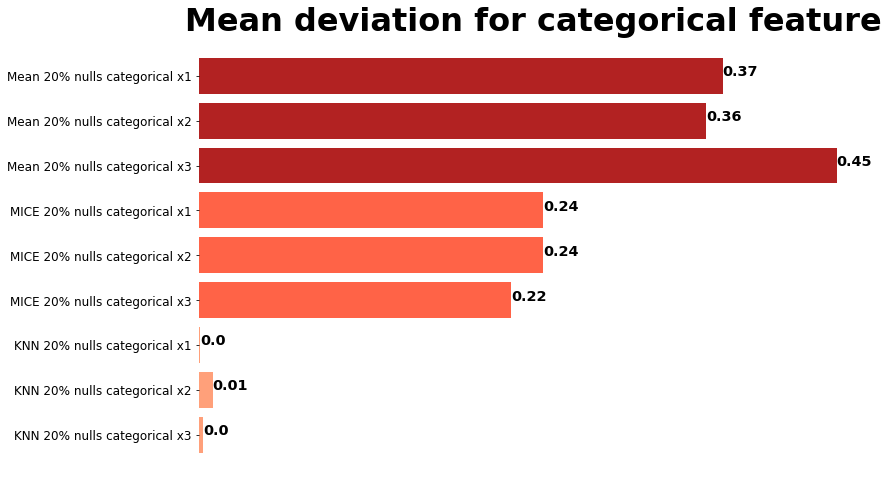

In [8]:
# Create the lists with values and labels
values_mean20 = [
    results20["Mean_20nulls_Cat_x1_raw"],
    results20["Mean_20nulls_Cat_x2_raw"],
    results20["Mean_20nulls_Cat_x3_raw"],
]

values_mice20 = [
    results20["MICE_20nulls_Cat_x1_raw"],
    results20["MICE_20nulls_Cat_x2_raw"],
    results20["MICE_20nulls_Cat_x3_raw"],
]

values_knn20 = [
    results20["KNN_20nulls_Cat_x1_raw"],
    results20["KNN_20nulls_Cat_x2_raw"],
    results20["KNN_20nulls_Cat_x3_raw"],
]

labels_mean20 = ["Mean 20% nulls categorical x1", "Mean 20% nulls categorical x2", "Mean 20% nulls categorical x3"]

labels_mice20 = ["MICE 20% nulls categorical x1", "MICE 20% nulls categorical x2", "MICE 20% nulls categorical x3"]

labels_knn20 = ["KNN 20% nulls categorical x1", "KNN 20% nulls categorical x2", "KNN 20% nulls categorical x3"]

# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y=labels_mean20, width=values_mean20, color="firebrick")
ax.barh(y=labels_mice20, width=values_mice20, color="tomato")
ax.barh(y=labels_knn20, width=values_knn20, color="lightsalmon")

# Title
plt.title("Mean deviation for categorical feature", fontsize=32, fontweight="bold")

# Remove all the four spines and x-axis
for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
plt.xticks([])    

# Modify labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Include values
for index, value in zip(range(0,3), values_mean20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

for index, value in zip(range(3,6), values_mice20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")
    
for index, value in zip(range(6,9), values_knn20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

# Invert location of y-axis
plt.gca().invert_yaxis()

# Plot the results
plt.show()

The analysis above shows that mean imputation was the worst performing method, specially when dealing with the categorical variable x3, which has a more complex relationship with the other features. <ins>KNN stands out as the best imputer</ins>.

#### Categorical feature with rounded predictions

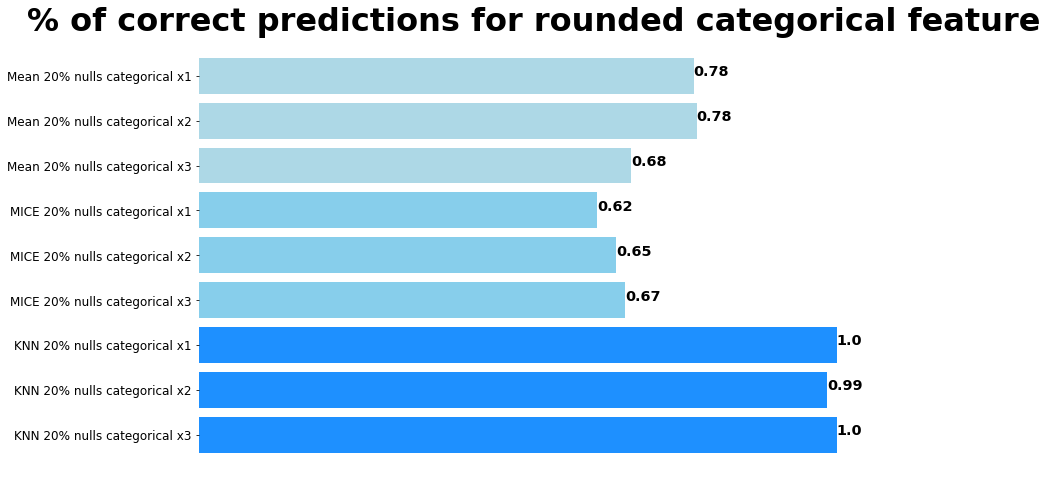

In [9]:
# Create the lists with values and labels
values_mean20 = [
    results20["Mean_20nulls_Cat_x1_round"],
    results20["Mean_20nulls_Cat_x2_round"],
    results20["Mean_20nulls_Cat_x3_round"],
]

values_mice20 = [
    results20["MICE_20nulls_Cat_x1_round"],
    results20["MICE_20nulls_Cat_x2_round"],
    results20["MICE_20nulls_Cat_x3_round"],
]

values_knn20 = [
    results20["KNN_20nulls_Cat_x1_round"],
    results20["KNN_20nulls_Cat_x2_round"],
    results20["KNN_20nulls_Cat_x3_round"],
]

labels_mean20 = ["Mean 20% nulls categorical x1", "Mean 20% nulls categorical x2", "Mean 20% nulls categorical x3"]

labels_mice20 = ["MICE 20% nulls categorical x1", "MICE 20% nulls categorical x2", "MICE 20% nulls categorical x3"]

labels_knn20 = ["KNN 20% nulls categorical x1", "KNN 20% nulls categorical x2", "KNN 20% nulls categorical x3"]

# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y=labels_mean20, width=values_mean20, color="lightblue")
ax.barh(y=labels_mice20, width=values_mice20, color="skyblue")
ax.barh(y=labels_knn20, width=values_knn20, color="dodgerblue")

# Title
plt.title("% of correct predictions for rounded categorical feature", fontsize=32, fontweight="bold")

# Remove all the four spines and x-axis
for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
plt.xticks([])    

# Modify labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Include values
for index, value in zip(range(0,3), values_mean20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

for index, value in zip(range(3,6), values_mice20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")
    
for index, value in zip(range(6,9), values_knn20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

# Invert location of y-axis
plt.gca().invert_yaxis()

# Plot the results
plt.show()

The analysis above shows that MICE imputation was the worst performing method. <ins>KNN stands out as the best imputer</ins>.

#### Numerical feature

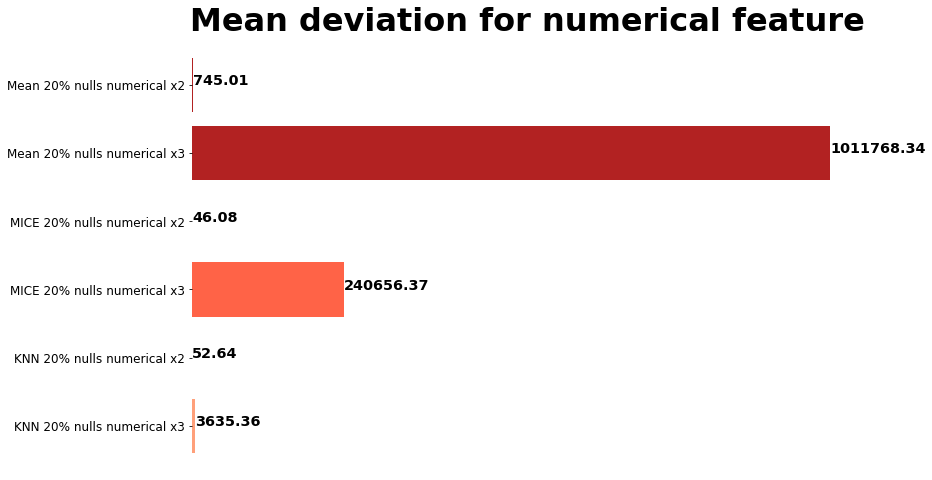

In [10]:
# Create the lists with values and labels
values_mean20 = [
    results20["Mean_20nulls_x2"],
    results20["Mean_20nulls_x3"],
]

values_mice20 = [
    results20["MICE_20nulls_x2"],
    results20["MICE_20nulls_x3"],
]

values_knn20 = [
    results20["KNN_20nulls_x2"],
    results20["KNN_20nulls_x3"],
]

labels_mean20 = ["Mean 20% nulls numerical x2", "Mean 20% nulls numerical x3"]

labels_mice20 = ["MICE 20% nulls numerical x2", "MICE 20% nulls numerical x3"]

labels_knn20 = ["KNN 20% nulls numerical x2", "KNN 20% nulls numerical x3"]

# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y=labels_mean20, width=values_mean20, color="firebrick")
ax.barh(y=labels_mice20, width=values_mice20, color="tomato")
ax.barh(y=labels_knn20, width=values_knn20, color="lightsalmon")

# Title
plt.title("Mean deviation for numerical feature", fontsize=32, fontweight="bold")

# Remove all the four spines and x-axis
for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
plt.xticks([])    

# Modify labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Include values
for index, value in zip(range(0,2), values_mean20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

for index, value in zip(range(2,4), values_mice20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")
    
for index, value in zip(range(4,6), values_knn20):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

# Invert location of y-axis
plt.gca().invert_yaxis()

# Plot the results
plt.show()

The analysis above shows that mean imputation was the worst performing method, specially when dealing with the numerical variable x3, which has a more complex relationship with the other features. MICE and KNN imputers performed similarly with numerical variable x2, however KNN performed far better with numerical variable x3. <ins>KNN stands out as the best imputer</ins>.

### 2.b) 80% null values <a class="anchor" id="bullet-2b"></a>

#### Categorical feature with raw predictions

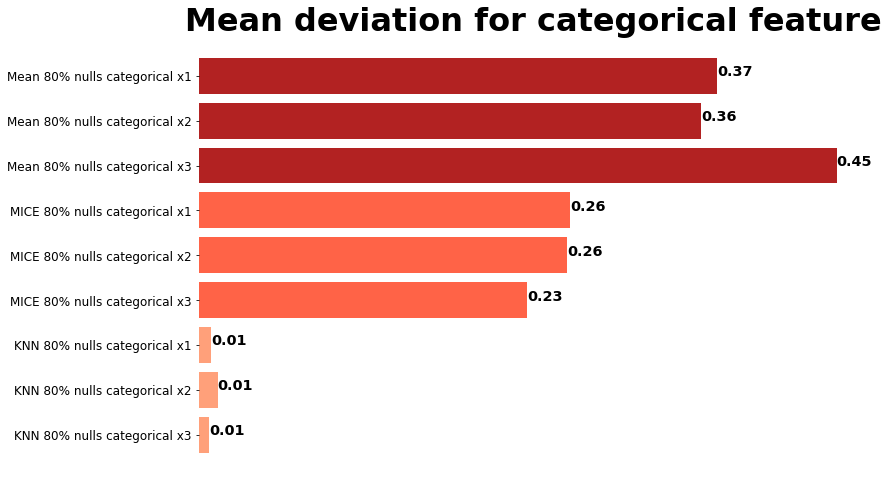

In [11]:
# Create the lists with values and labels
values_mean80 = [
    results80["Mean_80nulls_Cat_x1_raw"],
    results80["Mean_80nulls_Cat_x2_raw"],
    results80["Mean_80nulls_Cat_x3_raw"],
]

values_mice80 = [
    results80["MICE_80nulls_Cat_x1_raw"],
    results80["MICE_80nulls_Cat_x2_raw"],
    results80["MICE_80nulls_Cat_x3_raw"],
]

values_knn80 = [
    results80["KNN_80nulls_Cat_x1_raw"],
    results80["KNN_80nulls_Cat_x2_raw"],
    results80["KNN_80nulls_Cat_x3_raw"],
]

labels_mean80 = ["Mean 80% nulls categorical x1", "Mean 80% nulls categorical x2", "Mean 80% nulls categorical x3"]

labels_mice80 = ["MICE 80% nulls categorical x1", "MICE 80% nulls categorical x2", "MICE 80% nulls categorical x3"]

labels_knn80 = ["KNN 80% nulls categorical x1", "KNN 80% nulls categorical x2", "KNN 80% nulls categorical x3"]

# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y=labels_mean80, width=values_mean80, color="firebrick")
ax.barh(y=labels_mice80, width=values_mice80, color="tomato")
ax.barh(y=labels_knn80, width=values_knn80, color="lightsalmon")

# Title
plt.title("Mean deviation for categorical feature", fontsize=32, fontweight="bold")

# Remove all the four spines and x-axis
for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
plt.xticks([])    

# Modify labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Include values
for index, value in zip(range(0,3), values_mean80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

for index, value in zip(range(3,6), values_mice80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")
    
for index, value in zip(range(6,9), values_knn80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

# Invert location of y-axis
plt.gca().invert_yaxis()

# Plot the results
plt.show()

The analysis above shows that mean imputation was the worst performing method, specially when dealing with the categorical variable x3, which has a more complex relationship with the other features. <ins>KNN stands out as the best imputer</ins>.

#### Categorical feature with rounded predictions

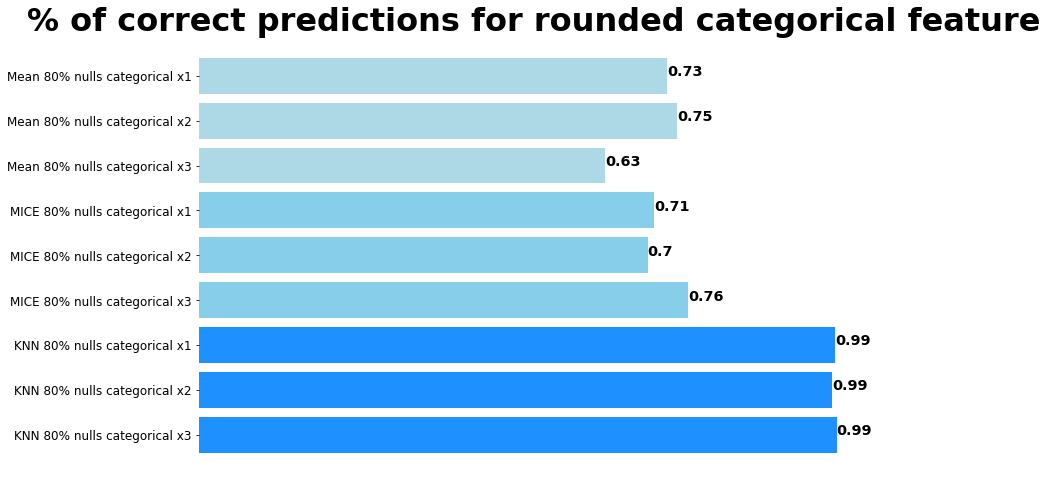

In [12]:
# Create the lists with values and labels
values_mean80 = [
    results80["Mean_80nulls_Cat_x1_round"],
    results80["Mean_80nulls_Cat_x2_round"],
    results80["Mean_80nulls_Cat_x3_round"],
]

values_mice80 = [
    results80["MICE_80nulls_Cat_x1_round"],
    results80["MICE_80nulls_Cat_x2_round"],
    results80["MICE_80nulls_Cat_x3_round"],
]

values_knn80 = [
    results80["KNN_80nulls_Cat_x1_round"],
    results80["KNN_80nulls_Cat_x2_round"],
    results80["KNN_80nulls_Cat_x3_round"],
]

labels_mean80 = ["Mean 80% nulls categorical x1", "Mean 80% nulls categorical x2", "Mean 80% nulls categorical x3"]

labels_mice80 = ["MICE 80% nulls categorical x1", "MICE 80% nulls categorical x2", "MICE 80% nulls categorical x3"]

labels_knn80 = ["KNN 80% nulls categorical x1", "KNN 80% nulls categorical x2", "KNN 80% nulls categorical x3"]

# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y=labels_mean80, width=values_mean80, color="lightblue")
ax.barh(y=labels_mice80, width=values_mice80, color="skyblue")
ax.barh(y=labels_knn80, width=values_knn80, color="dodgerblue")

# Title
plt.title("% of correct predictions for rounded categorical feature", fontsize=32, fontweight="bold")

# Remove all the four spines and x-axis
for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
plt.xticks([])    

# Modify labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Include values
for index, value in zip(range(0,3), values_mean80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

for index, value in zip(range(3,6), values_mice80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")
    
for index, value in zip(range(6,9), values_knn80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

# Invert location of y-axis
plt.gca().invert_yaxis()

# Plot the results
plt.show()

The analysis above shows that mean and MICE imputation performed similarly. <ins>KNN stands out as the best imputer</ins>.

#### Numerical feature

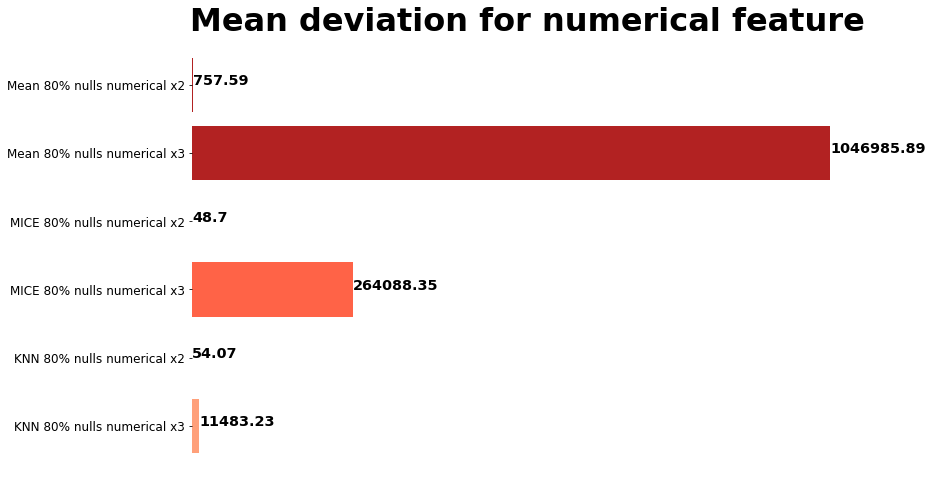

In [13]:
# Create the lists with values and labels
values_mean80 = [
    results80["Mean_80nulls_x2"],
    results80["Mean_80nulls_x3"],
]

values_mice80 = [
    results80["MICE_80nulls_x2"],
    results80["MICE_80nulls_x3"],
]

values_knn80 = [
    results80["KNN_80nulls_x2"],
    results80["KNN_80nulls_x3"],
]

labels_mean80 = ["Mean 80% nulls numerical x2", "Mean 80% nulls numerical x3"]

labels_mice80 = ["MICE 80% nulls numerical x2", "MICE 80% nulls numerical x3"]

labels_knn80 = ["KNN 80% nulls numerical x2", "KNN 80% nulls numerical x3"]

# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y=labels_mean80, width=values_mean80, color="firebrick")
ax.barh(y=labels_mice80, width=values_mice80, color="tomato")
ax.barh(y=labels_knn80, width=values_knn80, color="lightsalmon")

# Title
plt.title("Mean deviation for numerical feature", fontsize=32, fontweight="bold")

# Remove all the four spines and x-axis
for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
plt.xticks([])    

# Modify labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Include values
for index, value in zip(range(0,2), values_mean80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

for index, value in zip(range(2,4), values_mice80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")
    
for index, value in zip(range(4,6), values_knn80):
    plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

# Invert location of y-axis
plt.gca().invert_yaxis()

# Plot the results
plt.show()

The analysis above shows that mean imputation was the worst performing method, specially when dealing with the numerical variable x3, which has a more complex relationship with the other features. MICE and KNN imputers performed similarly with numerical variable x2, however KNN performed far better with numerical variable x3. <ins>KNN stands out as the best imputer</ins>.

## 3. Model predictions results <a class="anchor" id="bullet-3"></a>

#### Create additional strategy: drop null values

In [14]:
# Create dataframes with dropped null values
drop_df20_x = df_del20.dropna(axis=0)
drop_df20_y = y_del20.dropna(axis=0)
drop_df80_x = df_del80.dropna(axis=0)
drop_df80_y = y_del80.dropna(axis=0)

#### Create the Linear Regression models and test accuracies

In [15]:
# Create lists with dataframes and names to iterate over
dataframes = [mean_df20, mean_df80, imp_df20_mice, imp_df80_mice, imp_df20_knn, imp_df80_knn, drop_df20_x, drop_df80_x]
df_names = ["Mean 20% nulls", "Mean 80% nulls", "MICE 20% nulls", "MICE 80% nulls", "KNN 20% nulls", "KNN 80% nulls",
           "Drop 20% nulls", "Drop 80% nulls"]

# Initiate dictionary to store RMSE values
models_rmse = {}

# Iterate over dataframes to calculate RMSE values of Linear Regression models
for df, df_name in zip(dataframes, df_names):
    
    # Initiate Linear Regression model
    lr = LinearRegression()
    
    # If the strategy was to drop null values, we need a y-values dataset that has the same number of rows
    if df_name in ("Drop 20% nulls", "Drop 80% nulls"):
        if df_name == "Drop 20% nulls":
            lr.fit(df[df.index < 900], drop_df20_y[drop_df20_y.index < 900])
        elif df_name == "Drop 80% nulls":
            lr.fit(df[df.index < 900], drop_df80_y[drop_df80_y.index < 900])
        
        # Make predictions using the original values, as otherwise we would have null values on our test data
        predictions = lr.predict(df_com[df_com.index >= 900])
    
    # If the strategy followed any imputation method, we'll simply continue fitting the model on the first 90% of the dataset
    else:
        lr.fit(df[df.index < 900], y_com[y_com.index < 900])
    
        # Make predictions on the remaining 10% of the dataset
        predictions = lr.predict(df[df.index >= 900])
    
    # Use the correct y values to calculate RMSE values and add it to dictionary
    y_test = y_com[y_com.index >= 900]
    rmse = np.sqrt(mean_squared_error(predictions, y_test))
    models_rmse[df_name] = rmse

#### Plot the results

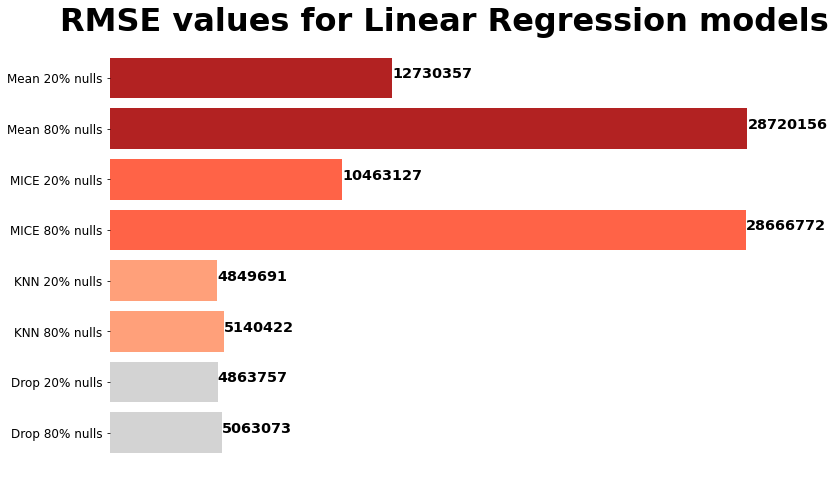

In [16]:
rmse_values = list(models_rmse.values())

# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y=df_names, width=rmse_values, color= ["firebrick", "firebrick", "tomato", "tomato",
                                                     "lightsalmon", "lightsalmon", "lightgray", "lightgray"])

# Title
plt.title("RMSE values for Linear Regression models", fontsize=32, fontweight="bold")

# Remove all the four spines and x-axis
for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
plt.xticks([])    

# Modify labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Include values
for index, value in zip(range(0,8), rmse_values):
    plt.text(value, index, str(int(value)), fontsize="x-large", fontweight="bold")

# Invert location of y-axis
plt.gca().invert_yaxis()

# Plot the results
plt.show()

The analysis above shows that mean imputation was the worst performing method when 20% null values were in place, while both mean and MICE imputation methods yielded similar results when dealing with 80% null values.

KNN imputer performed similarly than dropping null values, having the best scores. This is really important, because it means that we can achieve excellent results with KNN imputer, while not dropping any row at all. <ins>KNN stands out as the best imputer</ins>.

## 4. Conclusions <a class="anchor" id="bullet-4"></a>

Two general assertions can be drawn from the present project:

1. When comparing the accuracy of the imputed values in x features, KNN achieved the best results consistently.

2. When using the imputed values to predict target feature y, KNN got similar results than dropping null values. However, dropping null values makes it impossible to predict on future data if it comes with null values (that's why we have trained the model on the datasets with dropped rows, but predicted on the original dataset with all the data).

Therefore, we can conclude that <ins>KNN Imputer stands as the best option to deal with null values</ins>.